<a href="https://colab.research.google.com/github/S1R3S1D/PINNs/blob/main/PINN_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm import tqdm

In [ ]:
def pop_growth(r:float, t):
  return r*(t**3/3-t**2/2)

def oscillator(d, w0, x):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [ ]:
x = torch.linspace(0, 2, 1000).view(-1, 1)
y = oscillator(2, 20, x).view(-1, 1)

x_data = x[0:200:10]
y_data = y[0:200:10]

In [ ]:
print(x_data.shape)

torch.Size([20, 1])


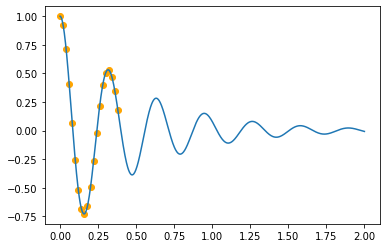

In [ ]:
plt.plot(x, y, label='Eqn')
plt.scatter(x_data, y_data, label='Data Points', color='orange')
plt.show()

In [ ]:
class NNApprox_fn(nn.Module):
  def __init__(self):
    super().__init__()

    self.FC1 = nn.Linear(1, 64)
    self.AC1 = nn.Tanh()

    self.FC2 = nn.Linear(64, 1024)
    self.AC2 = nn.Tanh()

    self.FC3 = nn.Linear(1024, 1)
    self.AC3 = nn.Tanh()

    self.FC4 = nn.Linear(64, 1)

  def forward(self, x):
    out = self.AC1(self.FC1(x))
    out = self.AC2(self.FC2(out))
    out = self.FC3(out)
    # out = self.FC4(out)
    return out

In [ ]:
epochs = 2000
lr = 0.001
model_vanilla = NNApprox_fn()
optimizer = torch.optim.Adam(model_vanilla.parameters(), lr=lr)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
model_vanilla = model_vanilla.to(device)

In [ ]:
for _ in tqdm(range(epochs)):
  
  x_data = x_data.to(device)
  y_data = y_data.to(device)
  
  y_pred = model_vanilla(x_data)
  loss = torch.mean((y_pred-y_data)**2)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

100%|██████████| 2000/2000 [00:02<00:00, 681.20it/s]


In [ ]:
with torch.no_grad():
  y_w_model = model_vanilla(x)

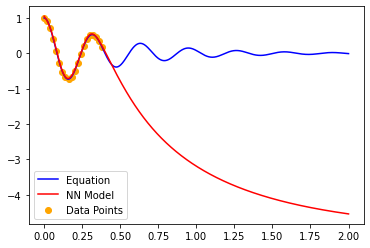

In [ ]:
plt.plot(x, y, color='blue', label='Equation')
plt.scatter(x_data, y_data, color='orange', label='Data Points')
plt.plot(x,y_w_model, color='red', label='NN Model')
plt.legend()
plt.show()

In [ ]:
epochs = 40000
lr = 0.0001
model_w_de = NNApprox_fn()
optimizer = torch.optim.Adam(model_w_de.parameters(), lr=lr)

In [ ]:
x_de = torch.linspace(0.0, 2.0, 100).view(-1, 1).requires_grad_(True)
d, w = 2, 20
mu, k = 2*d, w**2
for _ in tqdm(range(epochs)):

  #Data Loss
  y_preds = model_w_de(x_data)
  data_loss = torch.mean((y_preds-y_data)**2)

  #Equation Loss
  y_eqn = model_w_de(x_de)
  d_f = torch.autograd.grad(y_eqn, x_de, torch.ones_like(y_eqn), create_graph=True)[0]
  d_f2 = torch.autograd.grad(d_f, x_de, torch.ones_like(d_f), create_graph = True)[0]
  residual = d_f2 + mu*d_f + k*y_eqn
  de_loss = (1e-4)*torch.mean(residual**2)

  loss = data_loss + de_loss
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

100%|██████████| 40000/40000 [07:46<00:00, 85.72it/s]


In [ ]:
with torch.no_grad():
  y_2 = model_w_de(x)

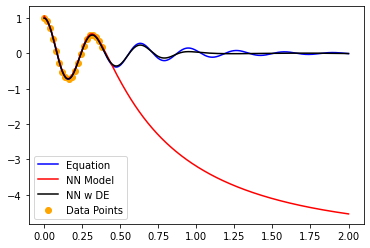

In [ ]:
plt.plot(x, y, color='blue', label='Equation')
plt.scatter(x_data, y_data, color='orange', label='Data Points')
plt.plot(x,y_w_model, color='red', label='NN Model')
plt.plot(x,y_2, color='black', label='NN w DE')
plt.legend()
plt.show()